# Energy and time Predictions for the kinarm reaching model. 

In the following code we create a kinarm model and perform optimizations to find the trajectories and movement times for reaches of different distances, and different valuations of time.

if you set 'theGeneratePlots=1', you will get 6 plots per optimization.


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3452
Number of nonzeros in inequality constraint Jacobian.:     1343
Number of nonzeros in Lagrangian Hessian.............:     1818

Total number of variables............................:     1099
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      632
Total number of inequality constraints...............:      795
        inequality constraints with only lower bounds:      306
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      489

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

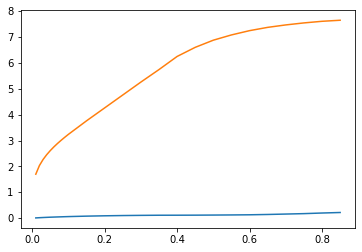

In [6]:
#%% Loop across distances and valuations to generate double-pendulum distance/time predictions. 
import ReachingModels as reaching
import numpy as np
import matplotlib.pyplot as plt
import colour as clr
import plotpresentlib as pp
from matplotlib.figure import Figure

DOSAVE = 1
savename = 'leftright85cmexcursiondoublependulum'
loopdist = np.concatenate((np.linspace(0.01,0.10,num=10),np.linspace(0.15,0.85,num=15)))
loopValuation = np.concatenate((np.array([0.1,.25,.5,.75]),np.linspace(1,50,num=50),np.array([100,150,200,250,300,350,400, 450, 500])))
# loopValuation = np.array([.10])

# test first?
# DOSAVE = 0
# loopdist = np.array([0.1])
# loopValuation = np.array([10])

#%config InlineBackend.figure_formats = ['svg'] #this is for interactive in visualstudiocode.
import sys
sys.path.insert(0,'parameterFiles')

# model that has equations to compute endpoint jacobians, equations of motion, and energy. 
sim = reaching.DoublePendulum()

# starting x and y
x = -0.35
ys = 0.25
xystart = np.array([x,ys])

#%% SETUP

# create color gradient tvalcolors.
color1 = clr.Color("#e0f3db")
tvalcolors = list(color1.range_to(clr.Color("#084081"),len(loopValuation)))

### allocate for storage:durations, speeds, costs, rewards, solved
M = len(loopValuation)
N = len(loopdist)
duration      = np.zeros([M, N])
peakspeed = np.zeros([M, N])
J             = np.zeros([M, N])
costFR        = np.zeros([M, N])
costWork      = np.zeros([M, N])
costTime      = np.zeros([M, N])
solved        = np.zeros([M, N])
distance      = np.zeros([M, N])
timeValuation = np.zeros([M, N])

#%% Run it once. 

traj = [[0 for x in range(N)] for y in range(M)] 

### SETUP
optiPrev = sim.movementTimeOptSetup(
  theTimeValuation  = 1.0,
  theN              = 60,   #2022-10: 20 and 40 both work flawlessly. this is after removing accel = 0 constraint. 
  theFRCoef         = 0.085)

### SOLVE
trajOrig, optiOrig = sim.updateGuessAndSolve(
  optiPrev, 
  xystart, 
  xystart + np.array([.1,0]),
  theDurationGuess    = 1,
  theTimeValuation    = 1,
  theGeneratePlots    = 0)

dGuess = trajOrig.duration

#%% store and save
for (nDist, valdist) in enumerate(loopdist):  
  for (mVal, valtval) in enumerate(loopValuation):
    trajResult, optiReturn = sim.updateGuessAndSolve(
      optiPrev, 
      xystart, 
      xystart + np.array([valdist,0]), 
      theDurationGuess  = dGuess,
      theTimeValuation    = valtval,
      theGeneratePlots    = 0)
    
    # if we found a solution:
    if trajResult.solved:
      # unpack the results
      duration[mVal,nDist]      = trajResult.duration
      J[mVal,nDist]             = trajResult.costJ
      costFR[mVal,nDist]        = trajResult.costFR
      costWork[mVal,nDist]      = trajResult.costWork
      costTime[mVal,nDist]      = trajResult.costTime
      peakspeed[mVal,nDist] = trajResult.peakspeed
      solved[mVal,nDist]        = trajResult.solved
      distance[mVal,nDist]     = valdist
      timeValuation[mVal,nDist] = valtval
      # update the optiPrev, only if solved == true.
      #optiPrev  = optiReturn
      dGuess    = trajResult.duration
      traj[mVal][nDist]=trajResult
    
    #increment inner
# %% SAVE
if DOSAVE:
  saveDict = {
    "duration":duration,
    "peakspeed":peakspeed,
    "distance":distance,
    "timeValuation":timeValuation,
    "traj":traj,
    "sim":sim}
  
  import scipy
  scipy.io.savemat('simulationResults/'+savename+'.mat', saveDict)

plt.plot(distance[0,:],peakspeed[0,:])
plt.plot(distance[0,:],duration[0,:])

Text(0, 0.5, 'peak speed')

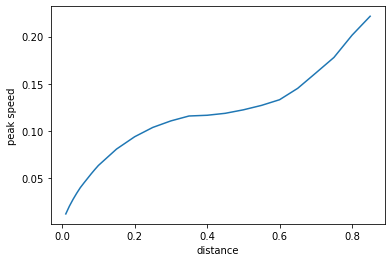

In [8]:
plt.plot(distance[0,:],peakspeed[0,:])
plt.xlabel('distance')
plt.ylabel('peak speed')
